<a href="https://colab.research.google.com/github/Skander28/LastWork/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
  !nvidia-smi
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Thu May 25 15:27:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |   5357MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [63]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Read the given dataset which contain the Ids
filtered_df = pd.read_csv('/content/drive/MyDrive/LastTry.csv',lineterminator='\n')
filtered_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,id,text,dialect,word_count,char_count
0,0,1152861142416576384,طيب اعرفو رئيس وزرائكم الاول وتعالو حاسبو رياض...,DZ,9,57
1,1,921392744878264448,@khaireddineroub اوكي ماتنساش روراوة ثاني لازم...,DZ,16,94
2,2,960133615689576448,@safasafa2339 يا ختي ديجا كي نشوف سمو نبدا نرج...,DZ,12,54
3,3,1121522092581769216,حسابشخصي حسابشخصي حسابشخصي اوو وش لي مش وخدين ...,DZ,10,54
4,4,1187345510874656768,@Hadjer12345678 تقولي راكي تهدري عليا 😂😂😂,DZ,6,41


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [65]:
import sentencepiece as spm

text_data = filtered_df['text'].tolist()

with open('tweets.txt', 'w', encoding='utf-8') as file:
    for tweet in text_data:
        file.write(tweet + '\n')
  
# Define the SentencePiece model path and vocabulary size
model_prefix = 'maghrebi_model'
vocab_size = 25000
max_length = 200

# Train the SentencePiece tokenizer
spm.SentencePieceTrainer.train(
    f'--input=tweets.txt --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type=unigram'
)

from torch.nn.utils.rnn import pad_sequence
# Load the trained SentencePiece tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f'{model_prefix}.model')

# Tokenize the text data
tokenized_data = [tokenizer.encode(text) for text in text_data]
tokenized_data = pad_sequences(tokenized_data, maxlen=max_length)

In [66]:
labels = pd.get_dummies(filtered_df['dialect']).values

In [67]:
# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size=0.05, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, shuffle=True)


In [68]:
import numpy as np

# Convert the one-hot encoded labels back to dialect labels
dialect_labels = np.argmax(labels, axis=1)
# Get the unique dialect labels and their counts in the original dataset
unique_dialects, dialect_counts = np.unique(dialect_labels, return_counts=True)

# Get the number of samples for each dialect in the training set
train_dialect_labels = np.argmax(y_train, axis=1)
train_dialect_counts = np.bincount(train_dialect_labels, minlength=len(unique_dialects))

# Get the number of samples for each dialect in the validation set
val_dialect_labels = np.argmax(y_val, axis=1)
val_dialect_counts = np.bincount(val_dialect_labels, minlength=len(unique_dialects))

# Get the number of samples for each dialect in the test set
test_dialect_labels = np.argmax(y_test, axis=1)
test_dialect_counts = np.bincount(test_dialect_labels, minlength=len(unique_dialects))

# Map dialect labels to their corresponding names
dialect_names = ["DZ", "LY", "MA", "TN"] 

# Print the number of samples for each dialect in each set
for dialect, train_count, val_count, test_count in zip(unique_dialects, train_dialect_counts, val_dialect_counts, test_dialect_counts):
    dialect_name = dialect_names[dialect]
    print(f"{dialect_name}: Train={train_count}, Val={val_count}, Test={test_count}")

DZ: Train=16283, Val=860, Test=864
LY: Train=16251, Val=834, Test=922
MA: Train=16210, Val=866, Test=931
TN: Train=16260, Val=862, Test=885


In [69]:
# Convert data to PyTorch tensors
X_train_, y_train_ = torch.tensor(X_train), torch.tensor(y_train)
X_val_, y_val_ = torch.tensor(X_val), torch.tensor(y_val)
X_test_, y_test_ = torch.tensor(X_test), torch.tensor(y_test)

In [70]:
class DialectDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [71]:
# Create dataloaders for training, validation, and test sets
train_dataset = DialectDataset(X_train_, y_train_)
val_dataset = DialectDataset(X_val_, y_val_)
test_dataset = DialectDataset(X_test_, y_test_)

In [72]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


# **LSTM Model**

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

output_dim = 100
batch_size = 64


class MyModel(nn.Module):
    def __init__(self, vocab_size, output_dim, max_length):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, output_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.lstm = nn.LSTM(output_dim, 50, dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(50, 25, dropout=0.3, batch_first=True)
        self.linear = nn.Linear(25, 4)
        softmax = nn.Softmax(dim=1)
        self.fc = nn.Sequential(self.linear, softmax)
    
    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        lstm_out, _ = self.lstm(dropped)
        lstm2_out, _ = self.lstm2(lstm_out)
        out = self.fc(lstm2_out[:, -1, :])
        return out
     

In [74]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import numpy as np
# import torch.nn.functional as F


# batch_size = 64
# # Define hyperparameters
# vocab_size = 25000
# emb_dim = 100
# num_filters = 10
# filter_sizes = [3, 8]
# hidden_dim = 100
# num_classes = 4
# dropout_rate = 0.5

# class MyModel(nn.Module):
#     def __init__(self, vocab_size, emb_dim, num_filters, filter_sizes, hidden_dim, num_classes, dropout_rate):
#         super(MyModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, emb_dim)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.conv1 = nn.Conv1d(emb_dim, num_filters, filter_sizes[0], padding=1)
#         self.conv2 = nn.Conv1d(emb_dim, num_filters, filter_sizes[1], padding=4)
#         self.pool = nn.MaxPool1d(2)
#         self.lstm = nn.LSTM(num_filters * 2, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)
#         x = self.dropout(x)

#         x = x.permute(0, 2, 1)  # Convert to (batch_size, emb_dim, seq_len)

#         conv_out1 = F.relu(self.conv1(x))
#         conv_out2 = F.relu(self.conv2(x))

#         pooled_out1 = self.pool(conv_out1).squeeze(2)
#         pooled_out2 = self.pool(conv_out2).squeeze(2)

#         x = torch.cat((pooled_out1, pooled_out2), dim=1)

#         lstm_out, _ = self.lstm(x)
#         lstm_out = lstm_out[:, -1, :]  # Get the last timestep's output

#         output = self.fc(lstm_out)
#         output = F.softmax(output, dim=1)

#         return output





In [75]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # # Split your dataset into training and validation sets
# # train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# # Convert your text data to numerical representation (e.g., using tokenization and padding)

# # Define hyperparameters
# param_grid = {
#     'emb_dim': [100, 200],
#     'num_filters': [10, 20],
#     'filter_sizes': [[3, 8], [5, 10]],
#     'hidden_dim': [100, 200],
#     'dropout_rate': [0.5, 0.7]
# }

# # Perform grid search
# best_accuracy = 0
# best_params = {}
# for emb_dim in param_grid['emb_dim']:
#     for num_filters in param_grid['num_filters']:
#         for filter_sizes in param_grid['filter_sizes']:
#             for hidden_dim in param_grid['hidden_dim']:
#                 for dropout_rate in param_grid['dropout_rate']:
#                     model = MyModel(vocab_size, emb_dim, num_filters, filter_sizes, hidden_dim, num_classes, dropout_rate)
#                     optimizer = optim.Adam(model.parameters())
#                     criterion = nn.CrossEntropyLoss()

#                     # Train the model
#                     for epoch in range(100):
#                                           model.train()
#                                           running_loss = 0.0
#                                           with torch.cuda.device(0):
#                                             for batch in train_dataloader:
#                                               inputs, labels = batch[0].to(device), batch[1].to(device)
#                                               optimizer.zero_grad()
#                                               labels = labels.float()
#                                               outputs = model(inputs)
#                                               loss = criterion(outputs, labels)
#                                               loss.backward()
#                                               optimizer.step()
#                                               running_loss += loss.item()
#                                             epoch_loss = running_loss / (len(train_dataloader))

#                                           val_loss = 0.0
#                                           model.eval()
#                                           with torch.no_grad():
#                                             for batch in val_dataloader:
#                                               inputs, labels = batch[0].to(device), batch[1].to(device)
#                                               labels = labels.float()
#                                               outputs = model(inputs)
#                                               loss = criterion(outputs, labels)
#                                               val_loss += loss.item()
#                                             val_loss /= len(val_dataloader)

#                                             print("Epoch: {}/{} | Train Loss: {:.4f} | Val Loss: {:.4f}".format(epoch+1, 100, epoch_loss, val_loss))

#                     # Check if this set of hyperparameters is the best
#                     if val_accuracy > best_accuracy:
#                         best_accuracy = val_accuracy
#                         best_params = {
#                             'emb_dim': emb_dim,
#                             'num_filters': num_filters,
#                             'filter_sizes': filter_sizes,
#                             'hidden_dim': hidden_dim,
#                             'dropout_rate': dropout_rate
#                         }

# print("Best hyperparameters:", best_params)
# print("Best accuracy:", best_accuracy)


In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel(vocab_size, output_dim, max_length).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
patience = 5
early_stopping_counter = 0

for epoch in tqdm(range(100)):
    model.train()
    running_loss = 0.0
    with torch.cuda.device(0):
      for batch in train_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        labels = labels.float()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / (len(train_dataloader))

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            labels = labels.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    print("Epoch: {}/{} | Train Loss: {:.4f} | Val Loss: {:.4f}".format(epoch+1, 100, epoch_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break
        

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:07<13:02,  7.91s/it]

Epoch: 1/100 | Train Loss: 0.7464 | Val Loss: 0.7235


  2%|▏         | 2/100 [00:13<10:40,  6.53s/it]

Epoch: 2/100 | Train Loss: 0.7245 | Val Loss: 0.7024


  3%|▎         | 3/100 [00:19<10:20,  6.40s/it]

Epoch: 3/100 | Train Loss: 0.7088 | Val Loss: 0.6902


  4%|▍         | 4/100 [00:25<09:51,  6.16s/it]

Epoch: 4/100 | Train Loss: 0.6980 | Val Loss: 0.6842


  5%|▌         | 5/100 [00:31<09:30,  6.01s/it]

Epoch: 5/100 | Train Loss: 0.6900 | Val Loss: 0.6799


  6%|▌         | 6/100 [00:37<09:32,  6.09s/it]

Epoch: 6/100 | Train Loss: 0.6845 | Val Loss: 0.6755


  7%|▋         | 7/100 [00:43<09:10,  5.92s/it]

Epoch: 7/100 | Train Loss: 0.6794 | Val Loss: 0.6718


  8%|▊         | 8/100 [00:49<09:18,  6.07s/it]

Epoch: 8/100 | Train Loss: 0.6741 | Val Loss: 0.6679


  9%|▉         | 9/100 [00:55<08:57,  5.91s/it]

Epoch: 9/100 | Train Loss: 0.6704 | Val Loss: 0.6674


 10%|█         | 10/100 [01:01<09:06,  6.07s/it]

Epoch: 10/100 | Train Loss: 0.6674 | Val Loss: 0.6648


 11%|█         | 11/100 [01:07<08:47,  5.93s/it]

Epoch: 11/100 | Train Loss: 0.6634 | Val Loss: 0.6644


 12%|█▏        | 12/100 [01:13<08:44,  5.96s/it]

Epoch: 12/100 | Train Loss: 0.6621 | Val Loss: 0.6631


 13%|█▎        | 13/100 [01:19<08:42,  6.01s/it]

Epoch: 13/100 | Train Loss: 0.6596 | Val Loss: 0.6619


 14%|█▍        | 14/100 [01:25<08:42,  6.08s/it]

Epoch: 14/100 | Train Loss: 0.6572 | Val Loss: 0.6620


 15%|█▌        | 15/100 [01:33<09:17,  6.56s/it]

Epoch: 15/100 | Train Loss: 0.6553 | Val Loss: 0.6568


 16%|█▌        | 16/100 [01:38<08:44,  6.25s/it]

Epoch: 16/100 | Train Loss: 0.6530 | Val Loss: 0.6594


 17%|█▋        | 17/100 [01:45<08:43,  6.31s/it]

Epoch: 17/100 | Train Loss: 0.6518 | Val Loss: 0.6565


 18%|█▊        | 18/100 [01:50<08:19,  6.09s/it]

Epoch: 18/100 | Train Loss: 0.6503 | Val Loss: 0.6572


 19%|█▉        | 19/100 [01:57<08:22,  6.21s/it]

Epoch: 19/100 | Train Loss: 0.6490 | Val Loss: 0.6544


 20%|██        | 20/100 [02:02<08:01,  6.02s/it]

Epoch: 20/100 | Train Loss: 0.6476 | Val Loss: 0.6542


 21%|██        | 21/100 [02:09<08:04,  6.13s/it]

Epoch: 21/100 | Train Loss: 0.6466 | Val Loss: 0.6527


 22%|██▏       | 22/100 [02:14<07:47,  5.99s/it]

Epoch: 22/100 | Train Loss: 0.6451 | Val Loss: 0.6517


 23%|██▎       | 23/100 [02:20<07:38,  5.96s/it]

Epoch: 23/100 | Train Loss: 0.6443 | Val Loss: 0.6515


 24%|██▍       | 24/100 [02:26<07:37,  6.02s/it]

Epoch: 24/100 | Train Loss: 0.6436 | Val Loss: 0.6509


 25%|██▌       | 25/100 [02:32<07:20,  5.87s/it]

Epoch: 25/100 | Train Loss: 0.6422 | Val Loss: 0.6497


 26%|██▌       | 26/100 [02:38<07:27,  6.05s/it]

Epoch: 26/100 | Train Loss: 0.6410 | Val Loss: 0.6506


 27%|██▋       | 27/100 [02:44<07:11,  5.92s/it]

Epoch: 27/100 | Train Loss: 0.6403 | Val Loss: 0.6489


 28%|██▊       | 28/100 [02:50<07:18,  6.09s/it]

Epoch: 28/100 | Train Loss: 0.6393 | Val Loss: 0.6481


 29%|██▉       | 29/100 [02:56<07:01,  5.94s/it]

Epoch: 29/100 | Train Loss: 0.6381 | Val Loss: 0.6495


 30%|███       | 30/100 [03:02<07:02,  6.04s/it]

Epoch: 30/100 | Train Loss: 0.6380 | Val Loss: 0.6492


 31%|███       | 31/100 [03:08<06:51,  5.96s/it]

Epoch: 31/100 | Train Loss: 0.6376 | Val Loss: 0.6484


 32%|███▏      | 32/100 [03:14<06:40,  5.89s/it]

Epoch: 32/100 | Train Loss: 0.6366 | Val Loss: 0.6475


 33%|███▎      | 33/100 [03:20<06:42,  6.01s/it]

Epoch: 33/100 | Train Loss: 0.6356 | Val Loss: 0.6475


 34%|███▍      | 34/100 [03:26<06:28,  5.89s/it]

Epoch: 34/100 | Train Loss: 0.6352 | Val Loss: 0.6472


 35%|███▌      | 35/100 [03:32<06:34,  6.06s/it]

Epoch: 35/100 | Train Loss: 0.6343 | Val Loss: 0.6469


 36%|███▌      | 36/100 [03:38<06:18,  5.91s/it]

Epoch: 36/100 | Train Loss: 0.6337 | Val Loss: 0.6471


 37%|███▋      | 37/100 [03:44<06:23,  6.09s/it]

Epoch: 37/100 | Train Loss: 0.6334 | Val Loss: 0.6462


 38%|███▊      | 38/100 [03:50<06:09,  5.95s/it]

Epoch: 38/100 | Train Loss: 0.6328 | Val Loss: 0.6470


 39%|███▉      | 39/100 [03:56<06:07,  6.02s/it]

Epoch: 39/100 | Train Loss: 0.6322 | Val Loss: 0.6463


 40%|████      | 40/100 [04:02<05:59,  5.99s/it]

Epoch: 40/100 | Train Loss: 0.6316 | Val Loss: 0.6464


 41%|████      | 41/100 [04:08<05:48,  5.90s/it]

Epoch: 41/100 | Train Loss: 0.6309 | Val Loss: 0.6473


 41%|████      | 41/100 [04:14<06:06,  6.21s/it]

Epoch: 42/100 | Train Loss: 0.6303 | Val Loss: 0.6468
Early stopping triggered. Training stopped.


# **Evaluation**

In [80]:
model.eval()
X_test_ = X_test_.to(device)
# Compute the model's prediction for the padded sequence
with torch.no_grad():
    pred_ = model(X_test_)
     
pred__ = pred_.cpu().numpy()
preds = np.argmax(pred__, axis=1)
     
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
pred_hot = one_hot(preds,4)
     
x_np = torch.from_numpy(pred_hot)
     

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
test_recall = recall_score(y_test, x_np,average='macro') 
test_prec = precision_score(y_test, x_np,average='macro') 
test_acc = accuracy_score(y_test, pred_hot)
test_f1 = f1_score(y_test, x_np,average='macro')

print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test F1 score: {:.4f}'.format(test_f1))
print('Test Precision: {:.4f}'.format(test_prec))
print('Test Recall: {:.4f}'.format(test_recall))


Test Accuracy: 0.8162
Test F1 score: 0.8155
Test Precision: 0.8183
Test Recall: 0.8152


Test Accuracy: 0.4134
Test F1 score: 0.5758
Test Precision: 0.4068
Test Recall: 0.9849


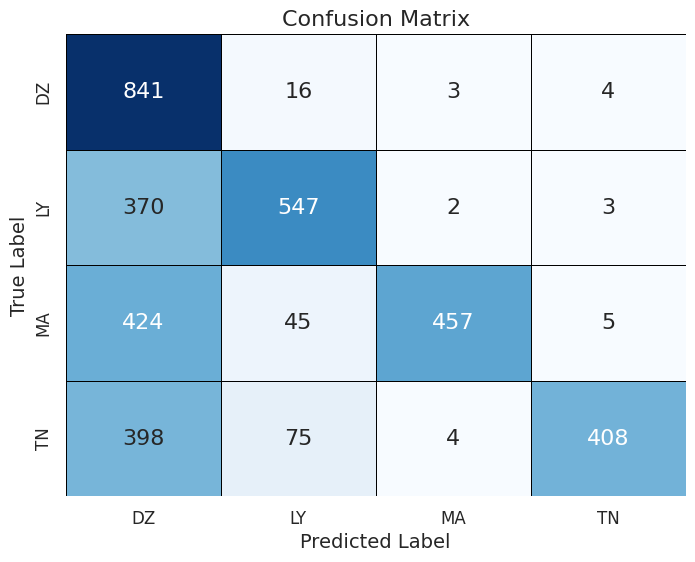

In [78]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns


model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        labels = labels.float()
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = metrics.accuracy_score(y_true, y_pred)
test_f1 = metrics.f1_score(y_true, y_pred, average='macro')
test_prec = metrics.precision_score(y_true, y_pred, average='macro')
test_recall = metrics.recall_score(y_true, y_pred, average='macro')

print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test F1 score: {:.4f}'.format(test_f1))
print('Test Precision: {:.4f}'.format(test_prec))
print('Test Recall: {:.4f}'.format(test_recall))

# Calculate confusion matrix
test_confusion_matrix = metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1, 2, 3])
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', ax=ax)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_xticklabels(["DZ", "LY", "MA", "TN"], fontsize=12)
ax.set_yticklabels(["DZ", "LY", "MA", "TN"], fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# **Testing**

In [ ]:
# # Set the model to evaluation mode
# model.eval()
# device = "cuda"
# # Tokenize the new complaint and pad the sequence
# new_complaint = ['واش دير للعشى']
# #new_complaint  = ["شوكران علا هاد "]
# #new_complaint  = ["نبي نروح للحوش"]
# #new_complaint  = ["شبيك شتحب "]
# seq = tokenizer.texts_to_sequences(new_complaint)
# padded = pad_sequences(seq, maxlen=max_length)

# # Convert the padded sequence to a PyTorch tensor and move it to the device (e.g., GPU) if available
# padded_tensor = torch.LongTensor(padded).to("cpu")

# # Compute the model's prediction for the padded sequence
# with torch.no_grad():
#     pred = model(padded_tensor)

# # Move the prediction back to the CPU and convert to a numpy array
# pred = pred.cpu().numpy()

# # Map the prediction to a class label using the CLASS_DICT{'DZ': 0, 'LY': 1, 'MA': 2, 'TN': 3}
# CLASS_DICT = {1: "LY", 3: "TN", 2: "MA", 0: "DZ" }
# class_label = CLASS_DICT[np.argmax(pred)]

# # Print the prediction and the predicted class label
# print(class_label)